In [1]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Load datasets
firearms_file = '/content/Firearms Data-Table 1.csv'
community_file = '/content/Community Data-Table 1.csv'
trend_file = '/content/Trend Data-Table 1.csv'
victims_file = '/content/Victims Data-Table 1.csv'

firearms_data = pd.read_csv(firearms_file)
community_data = pd.read_csv(community_file)
trend_data = pd.read_csv(trend_file)
victims_data = pd.read_csv(victims_file)

# Preprocess Firearms Data
firearms_data_cleaned = firearms_data.drop(columns=[col for col in firearms_data.columns if 'Unnamed' in col])
firearms_data_cleaned = firearms_data_cleaned.dropna(subset=["Case #"]).reset_index(drop=True)

# Preprocess Community Data
community_data_cleaned = community_data.drop(columns=[col for col in community_data.columns if 'Unnamed' in col])
community_data_cleaned = community_data_cleaned.dropna(subset=["Case #"]).reset_index(drop=True)

# Preprocess Trend Data
trend_data_cleaned = trend_data.drop(columns=[col for col in trend_data.columns if 'Unnamed' in col])
trend_data_cleaned['Year'] = pd.to_numeric(trend_data_cleaned['Year'], errors='coerce')
trend_data_cleaned = trend_data_cleaned.dropna(subset=['Year']).reset_index(drop=True)
trend_data_cleaned['Year'] = trend_data_cleaned['Year'].astype(int)

# Preprocess Victims Data
victims_data_cleaned = victims_data.drop(columns=[col for col in victims_data.columns if 'Unnamed' in col])
victims_data_cleaned = victims_data_cleaned.dropna(subset=["Case #", "Victim Name"]).reset_index(drop=True)

# Linking Datasets: Merge them on common keys
firearms_community_linked = pd.merge(
    firearms_data_cleaned, community_data_cleaned, on="Case #", how="inner"
)

firearms_community_victims_linked = pd.merge(
    firearms_community_linked, victims_data_cleaned, on="Case #", how="inner"
)

firearms_community_victims_linked['Year'] = pd.to_datetime(
    firearms_community_victims_linked['Full Date_x'], errors='coerce'
).dt.year

final_linked_data = pd.merge(
    firearms_community_victims_linked.dropna(subset=['Year']).astype({'Year': int}),
    trend_data_cleaned,
    on="Year",
    how="inner"
)

# Summary of the final linked dataset
print("Final Linked Data Shape:", final_linked_data.shape)
print("Columns in Final Linked Data:", list(final_linked_data.columns))


Final Linked Data Shape: (3139, 67)
Columns in Final Linked Data: ['Case #', 'Shooter Last Name_x', 'Shooter First Name_x', 'Full Date_x', 'Make and Model', 'Classification', 'Caliber', 'Used in Shooting?', 'Modified', 'Extended Magazine', 'When Obtained', 'Legal Purchase', 'Illegal Purchase', 'Assembled with Legal Parts ', 'Gifted', 'Theft', 'Unknown', 'Shooter Last Name_y', 'Shooter First Name_y', 'Location (Code)', 'Location (Specify)', 'Shooting Start Time', 'Shooting End Time', 'Time of Day', 'Zip Code', 'Total Population', 'Median Age', '% White Alone', '% Female Household', '% Rental Units', '% Employed', '% High School Graduate', '% College Graduate', '% Without Health Insurance', 'Nearest Hospital (Miles)', 'N Mental Health Providers in Zip Code', 'N Gun Stores in Zip Code', 'Size of Police Dept', 'Homicide Rate', 'Shooter Last Name', 'Shooter First Name', 'Full Date_y', 'Victim Name', 'Age', 'Gender', 'Race', 'Knew Shooter', 'If Known, Relationship to Shooter', 'Relationship 

<ipython-input-1-f50bb772264c>:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  firearms_community_victims_linked['Year'] = pd.to_datetime(


In [2]:
# Aggregate data to analyze mass shooting frequency by Zip Code
community_analysis = final_linked_data.groupby('Zip Code').agg({
    'Case #': 'count',  # Count of incidents
    '% Rental Units': 'mean',
    '% Employed': 'mean',
    '% High School Graduate': 'mean',
    '% College Graduate': 'mean',
    '% Without Health Insurance': 'mean',
    'N Mental Health Providers in Zip Code': 'mean',
    'N Gun Stores in Zip Code': 'mean'
}).rename(columns={'Case #': 'Shooting Count'})

print(community_analysis.head())


          Shooting Count  % Rental Units  % Employed  % High School Graduate  \
Zip Code                                                                       
(0)1880               28            28.0        66.5                    90.6   
(0)3576                8            29.3        60.4                    73.1   
(0)6042               24            42.9        68.3                    92.6   
(0)6067                4            19.4        64.5                    85.5   
(0)6482              135             NaN        66.2                    95.9   

          % College Graduate  % Without Health Insurance  \
Zip Code                                                   
(0)1880                 39.7                         NaN   
(0)3576                 11.1                        19.4   
(0)6042                 39.2                         NaN   
(0)6067                 29.1                         NaN   
(0)6482                 55.9                         2.6   

          N Mental

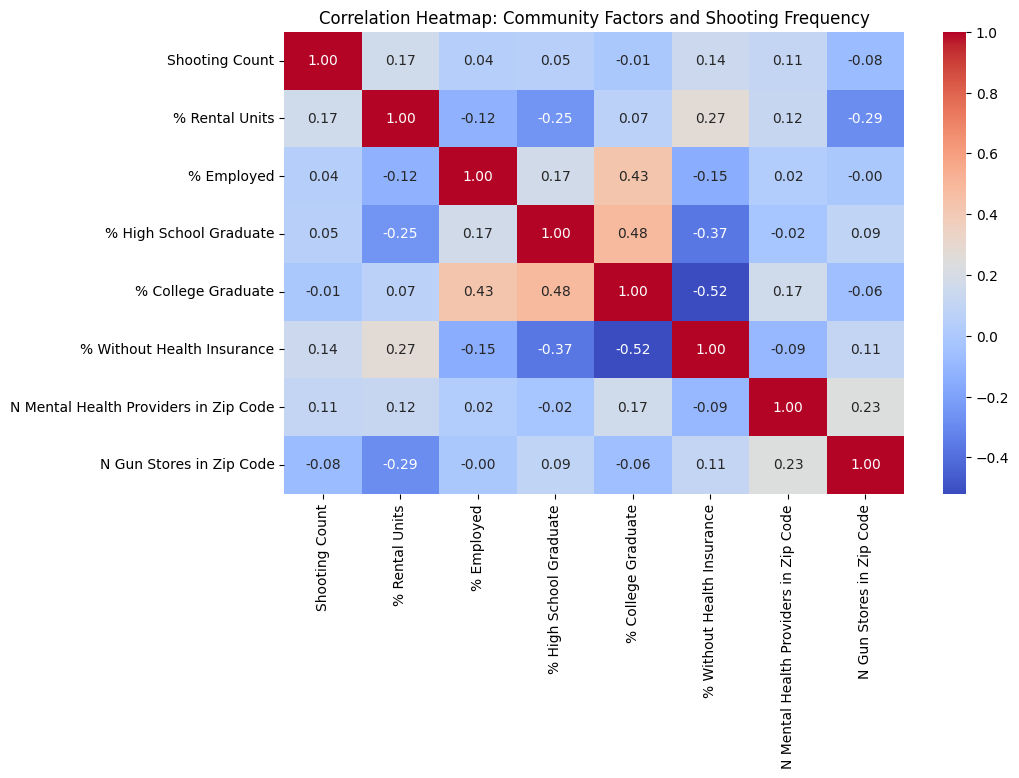

In [3]:
# Correlation heatmap to explore factors
plt.figure(figsize=(10, 6))
correlation_matrix = community_analysis.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap: Community Factors and Shooting Frequency")
plt.show()


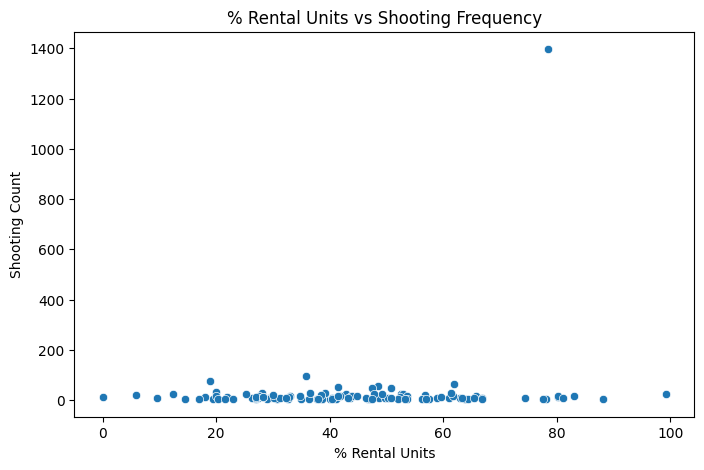

In [4]:
# Scatterplot: % Rental Units vs Shooting Count
plt.figure(figsize=(8, 5))
sns.scatterplot(x=community_analysis['% Rental Units'], y=community_analysis['Shooting Count'])
plt.title("% Rental Units vs Shooting Frequency")
plt.xlabel("% Rental Units")
plt.ylabel("Shooting Count")
plt.show()


In [5]:
# Prepare data for modeling
X = community_analysis[
    ['% Rental Units', '% Employed', '% High School Graduate', '% College Graduate',
     '% Without Health Insurance', 'N Mental Health Providers in Zip Code', 'N Gun Stores in Zip Code']
].fillna(0)
y = community_analysis['Shooting Count']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Model evaluation
model_performance = {
    "R-squared": r2_score(y_test, y_pred),
    "Mean Squared Error": mean_squared_error(y_test, y_pred)
}
print(model_performance)


{'R-squared': -11.037743410604428, 'Mean Squared Error': 9222.41332599199}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Binary Classification Metrics:
Accuracy: 0.782608695652174

Confusion Matrix:
 [[18  0]
 [ 5  0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.78      1.00      0.88        18
           1       0.00      0.00      0.00         5

    accuracy                           0.78        23
   macro avg       0.39      0.50      0.44        23
weighted avg       0.61      0.78      0.69        23


Continuous Metrics (Logistic Regression):
R-squared: -0.6443355833416264
Mean Squared Error: 1259.766210239498

Feature Importance:
                                  Feature  Coefficient
5  N Mental Health Providers in Zip Code     0.164137
4             % Without Health Insurance     0.053295
2                 % High School Graduate     0.012856
3                     % College Graduate     0.011831
1                             % Employed     0.006802
0                         % Rental Units     0.005007
6               N Gun Stores in Zip Co

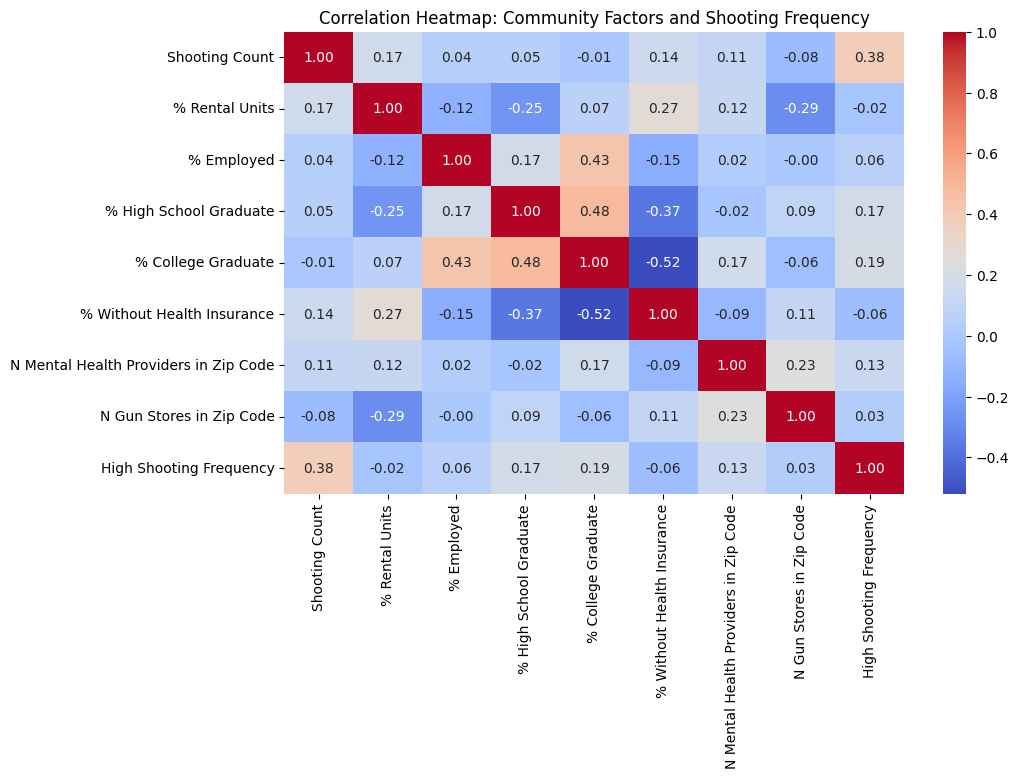

In [6]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, confusion_matrix, classification_report

# Step 1: Aggregate Data by Zip Code
community_analysis = final_linked_data.groupby('Zip Code').agg({
    'Case #': 'count',  # Count of incidents
    '% Rental Units': 'mean',
    '% Employed': 'mean',
    '% High School Graduate': 'mean',
    '% College Graduate': 'mean',
    '% Without Health Insurance': 'mean',
    'N Mental Health Providers in Zip Code': 'mean',
    'N Gun Stores in Zip Code': 'mean'
}).rename(columns={'Case #': 'Shooting Count'})

# Step 2: Create a Binary Target for Logistic Regression (Temporary)
threshold = community_analysis['Shooting Count'].mean()  # Use mean as the threshold
community_analysis['High Shooting Frequency'] = (community_analysis['Shooting Count'] > threshold).astype(int)

# Step 3: Prepare Data for Logistic Regression
X = community_analysis[
    ['% Rental Units', '% Employed', '% High School Graduate', '% College Graduate',
     '% Without Health Insurance', 'N Mental Health Providers in Zip Code', 'N Gun Stores in Zip Code']
].fillna(0)  # Fill missing values with 0
y_binary = community_analysis['High Shooting Frequency']  # Binary target
y_continuous = community_analysis['Shooting Count']  # Continuous target for R-squared and MSE comparison

# Step 4: Train-Test Split
X_train, X_test, y_train_binary, y_test_binary = train_test_split(X, y_binary, test_size=0.2, random_state=42)
_, _, y_train_continuous, y_test_continuous = train_test_split(X, y_continuous, test_size=0.2, random_state=42)

# Step 5: Logistic Regression Model
logistic_model = LogisticRegression(max_iter=500)
logistic_model.fit(X_train, y_train_binary)

# Step 6: Predictions for Both Binary and Continuous Metrics
y_pred_binary = logistic_model.predict(X_test)
y_pred_prob = logistic_model.predict_proba(X_test)[:, 1]  # Predicted probabilities for R-squared and MSE

# Step 7: Metrics for Binary Classification
accuracy = accuracy_score(y_test_binary, y_pred_binary)
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)
classification_rep = classification_report(y_test_binary, y_pred_binary)

# Step 8: Linear Regression Metrics
# Using predicted probabilities to calculate R-squared and MSE for comparison
logistic_r2 = r2_score(y_test_continuous, y_pred_prob)
logistic_mse = mean_squared_error(y_test_continuous, y_pred_prob)

# Step 9: Feature Importance
importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': logistic_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

# Display Results
print("Binary Classification Metrics:")
print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_rep)

print("\nContinuous Metrics (Logistic Regression):")
print("R-squared:", logistic_r2)
print("Mean Squared Error:", logistic_mse)

print("\nFeature Importance:\n", importance)

# Optional: Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(community_analysis.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap: Community Factors and Shooting Frequency")
plt.show()


In [7]:
# Import required libraries
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Prepare the Data
# Aggregate data
hypothesis_2_data = final_linked_data.groupby('Case #').agg({
    'Victim Name': 'count',  # Number of victims (casualties)
    'Years Lost': lambda x: pd.to_numeric(x, errors='coerce').mean(),  # Average years lost
    'Modified': 'first',  # Firearm modifications
    'Extended Magazine': 'first'  # Extended magazine
}).rename(columns={
    'Victim Name': 'Casualties',
    'Years Lost': 'Average Years Lost'
}).dropna()

# Define features and target for both models
X = hypothesis_2_data[['Modified', 'Extended Magazine']].fillna(0)
y_continuous = hypothesis_2_data['Casualties']  # Continuous target for linear regression
threshold = y_continuous.median()  # High casualty threshold for logistic regression
y_binary = (y_continuous > threshold).astype(int)

# Step 2: Train-Test Split
X_train, X_test, y_train_continuous, y_test_continuous = train_test_split(X, y_continuous, test_size=0.2, random_state=42)
_, _, y_train_binary, y_test_binary = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# Step 3: Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train_continuous)
y_pred_continuous = linear_model.predict(X_test)

# Linear Regression Metrics
linear_r2 = r2_score(y_test_continuous, y_pred_continuous)
linear_mse = mean_squared_error(y_test_continuous, y_pred_continuous)

print("Linear Regression Metrics:")
print("R-squared:", linear_r2)
print("Mean Squared Error:", linear_mse)

# Step 4: Logistic Regression
logistic_model = LogisticRegression(max_iter=500)
logistic_model.fit(X_train, y_train_binary)
y_pred_binary = logistic_model.predict(X_test)
y_pred_proba = logistic_model.predict_proba(X_test)[:, 1]

# Logistic Regression Metrics
logistic_accuracy = accuracy_score(y_test_binary, y_pred_binary)
logistic_confusion_matrix = confusion_matrix(y_test_binary, y_pred_binary)
logistic_classification_report = classification_report(y_test_binary, y_pred_binary)

# Compute "Pseudo R-squared" for Logistic Regression
logistic_r2 = r2_score(y_test_continuous, y_pred_proba)  # Use probabilities as a proxy for continuous output
logistic_mse = mean_squared_error(y_test_continuous, y_pred_proba)

print("\nLogistic Regression Metrics:")
print("Accuracy:", logistic_accuracy)
print("Pseudo R-squared:", logistic_r2)
print("Mean Squared Error:", logistic_mse)
print("\nConfusion Matrix:\n", logistic_confusion_matrix)
print("\nClassification Report:\n", logistic_classification_report)

# Optional: Feature Importance for Logistic Regression
importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': logistic_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("\nFeature Importance (Logistic Regression):\n", importance)


Linear Regression Metrics:
R-squared: -0.058912003700258175
Mean Squared Error: 91037.24860735382

Logistic Regression Metrics:
Accuracy: 0.5714285714285714
Pseudo R-squared: -0.08568513012768908
Mean Squared Error: 93338.99961032013

Confusion Matrix:
 [[8 0]
 [9 4]]

Classification Report:
               precision    recall  f1-score   support

           0       0.47      1.00      0.64         8
           1       1.00      0.31      0.47        13

    accuracy                           0.57        21
   macro avg       0.74      0.65      0.56        21
weighted avg       0.80      0.57      0.54        21


Feature Importance (Logistic Regression):
              Feature  Coefficient
1  Extended Magazine     0.697584
0           Modified     0.584348


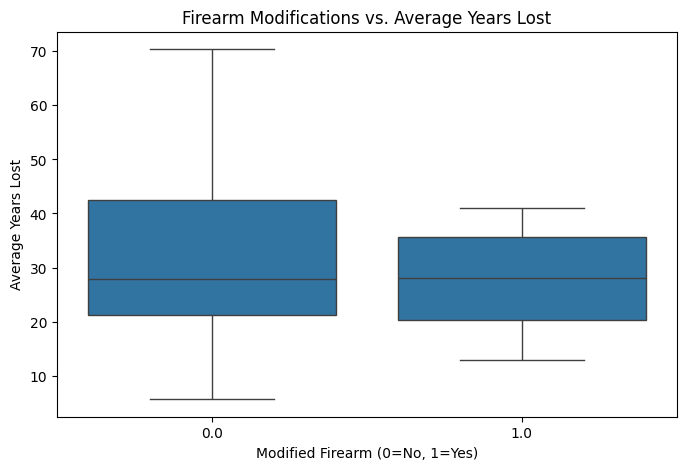

Linear Regression Metrics:
R-squared: 0.033198561294653595
Mean Squared Error: 279.84437099372974

Logistic Regression Metrics:
Accuracy: 0.5555555555555556
Pseudo R-squared: 0.02118342115418903
Mean Squared Error: 0.24470414471145274

Confusion Matrix:
 [[4 5]
 [3 6]]

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.44      0.50         9
           1       0.55      0.67      0.60         9

    accuracy                           0.56        18
   macro avg       0.56      0.56      0.55        18
weighted avg       0.56      0.56      0.55        18



In [8]:
# Step 1: Aggregate Data with Years of Life Lost
# Calculate average years lost per case and include firearm features
hypothesis_2_modified = final_linked_data.groupby('Case #').agg({
    'Victim Name': 'count',  # Number of victims
    'Years Lost': lambda x: pd.to_numeric(x, errors='coerce').mean(),  # Average years lost
    'Modified': 'first',  # Firearm modifications
    'Extended Magazine': 'first',  # Extended magazine
    'Caliber': 'first',  # Caliber of firearm
    'Classification': 'first'  # Firearm classification
}).rename(columns={
    'Victim Name': 'Casualties',
    'Years Lost': 'Average Years Lost'
}).dropna()

# Step 2: Exploratory Analysis
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot: Firearm Modifications vs. Average Years Lost
plt.figure(figsize=(8, 5))
sns.boxplot(x=hypothesis_2_modified['Modified'], y=hypothesis_2_modified['Average Years Lost'])
plt.title("Firearm Modifications vs. Average Years Lost")
plt.xlabel("Modified Firearm (0=No, 1=Yes)")
plt.ylabel("Average Years Lost")
plt.show()

# Step 3: Linear Regression - Predict Average Years Lost
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Prepare data
X = hypothesis_2_modified[['Modified', 'Extended Magazine', 'Caliber', 'Classification']].fillna(0)
y = hypothesis_2_modified['Average Years Lost']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predictions
y_pred = linear_model.predict(X_test)

# Linear Regression Metrics
linear_r2 = r2_score(y_test, y_pred)
linear_mse = mean_squared_error(y_test, y_pred)

print("Linear Regression Metrics:")
print("R-squared:", linear_r2)
print("Mean Squared Error:", linear_mse)

# Step 4: Logistic Regression - Classify High Years Lost Incidents
from sklearn.linear_model import LogisticRegression

# Define high-impact incidents (above median years lost)
threshold = hypothesis_2_modified['Average Years Lost'].median()
hypothesis_2_modified['High Impact'] = (hypothesis_2_modified['Average Years Lost'] > threshold).astype(int)

# Logistic Regression
X = hypothesis_2_modified[['Modified', 'Extended Magazine', 'Caliber', 'Classification']]
y = hypothesis_2_modified['High Impact']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
logistic_model = LogisticRegression(max_iter=500)
logistic_model.fit(X_train, y_train)

# Predictions
y_pred_log = logistic_model.predict(X_test)
y_pred_proba = logistic_model.predict_proba(X_test)[:, 1]

# Logistic Regression Metrics
logistic_accuracy = accuracy_score(y_test, y_pred_log)
logistic_confusion_matrix = confusion_matrix(y_test, y_pred_log)
logistic_classification_report = classification_report(y_test, y_pred_log)

# Compute "Pseudo R-squared" and MSE for Logistic Regression
logistic_r2 = r2_score(y_test, y_pred_proba)
logistic_mse = mean_squared_error(y_test, y_pred_proba)

print("\nLogistic Regression Metrics:")
print("Accuracy:", logistic_accuracy)
print("Pseudo R-squared:", logistic_r2)
print("Mean Squared Error:", logistic_mse)
print("\nConfusion Matrix:\n", logistic_confusion_matrix)
print("\nClassification Report:\n", logistic_classification_report)


Logistic Regression Metrics:
Accuracy: 1.0
Pseudo R-squared: 0.9996975403536416
Mean Squared Error: 6.067863275708723e-05

Confusion Matrix:
 [[13  0]
 [ 0  5]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00         5

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18


Feature Importance:
               Feature  Coefficient
3      Classification     0.262719
0            Modified     0.144860
1   Extended Magazine     0.034004
2             Caliber    -0.061963
5  Location (Specify)    -0.173068
4  Average Victim Age    -1.032722


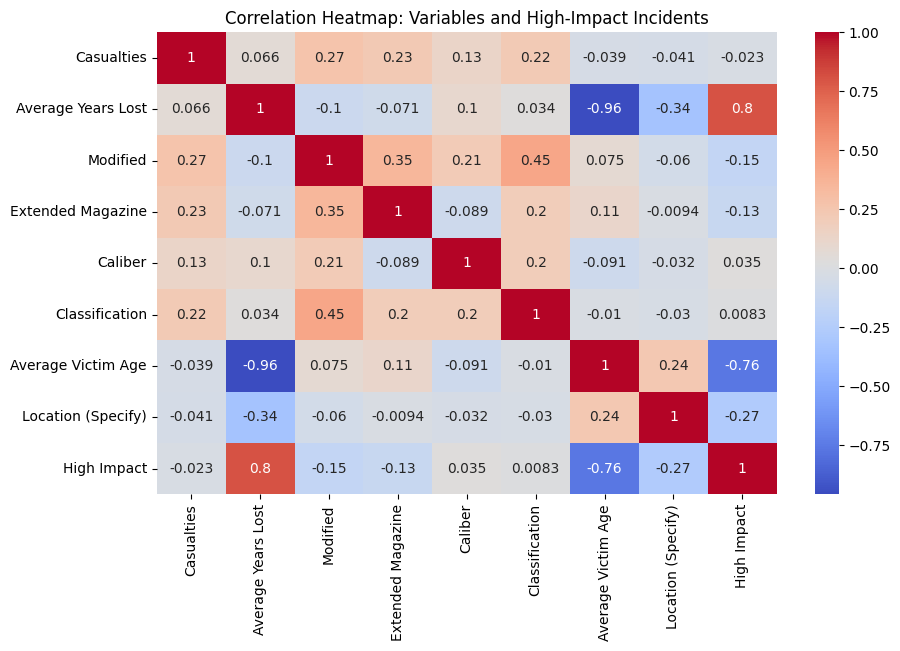

In [9]:
# Step 1: Aggregate Data with Demographics and Contextual Features
# Calculate average years lost per case, casualties, and include firearm features and demographics
hypothesis_2_revised = final_linked_data.groupby('Case #').agg({
    'Victim Name': 'count',  # Number of victims (casualties)
    'Years Lost': lambda x: pd.to_numeric(x, errors='coerce').mean(),  # Average years lost
    'Modified': 'first',  # Firearm modifications
    'Extended Magazine': 'first',  # Extended magazine
    'Caliber': 'first',  # Caliber of firearm
    'Classification': 'first',  # Firearm classification
    'Age': lambda x: pd.to_numeric(x, errors='coerce').mean(),  # Average victim age
    'Location (Specify)': 'first'  # Contextual factor
}).rename(columns={
    'Victim Name': 'Casualties',
    'Years Lost': 'Average Years Lost',
    'Age': 'Average Victim Age'
}).dropna()

# Step 2: Define High-Impact Incidents
# Use the top 25% of incidents based on Average Years Lost as the target
threshold_years_lost = hypothesis_2_revised['Average Years Lost'].quantile(0.75)
hypothesis_2_revised['High Impact'] = (hypothesis_2_revised['Average Years Lost'] > threshold_years_lost).astype(int)

# Step 3: Prepare Data for Logistic Regression
# Encode categorical features like location type
hypothesis_2_revised['Location (Specify)'] = hypothesis_2_revised['Location (Specify)'].astype('category').cat.codes

# Select features and target
X = hypothesis_2_revised[['Modified', 'Extended Magazine', 'Caliber', 'Classification',
                          'Average Victim Age', 'Location (Specify)']].fillna(0)
y = hypothesis_2_revised['High Impact']

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Logistic Regression Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, r2_score, mean_squared_error

logistic_model = LogisticRegression(max_iter=500)
logistic_model.fit(X_train, y_train)

# Predictions
y_pred = logistic_model.predict(X_test)
y_pred_proba = logistic_model.predict_proba(X_test)[:, 1]

# Logistic Regression Metrics
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification = classification_report(y_test, y_pred)
pseudo_r2 = r2_score(y_test, y_pred_proba)
mse = mean_squared_error(y_test, y_pred_proba)

# Step 5: Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': logistic_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

# Display Results
print("Logistic Regression Metrics:")
print("Accuracy:", accuracy)
print("Pseudo R-squared:", pseudo_r2)
print("Mean Squared Error:", mse)
print("\nConfusion Matrix:\n", confusion)
print("\nClassification Report:\n", classification)
print("\nFeature Importance:\n", feature_importance)

# Optional: Correlation Heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(hypothesis_2_revised.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap: Variables and High-Impact Incidents")
plt.show()


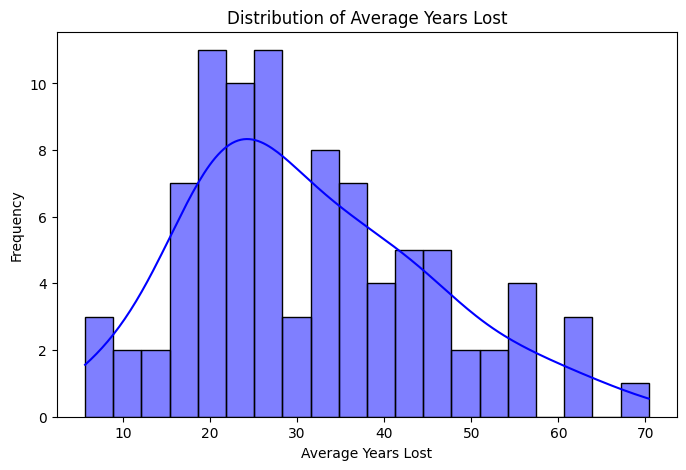

In [10]:
# Distribution of Average Years Lost
plt.figure(figsize=(8, 5))
sns.histplot(hypothesis_2_revised['Average Years Lost'], kde=True, bins=20, color='blue')
plt.title("Distribution of Average Years Lost")
plt.xlabel("Average Years Lost")
plt.ylabel("Frequency")
plt.show()


<ipython-input-11-8ffaec0beb6c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=hypothesis_2_revised['Modified'], y=hypothesis_2_revised['Average Years Lost'], palette="coolwarm")


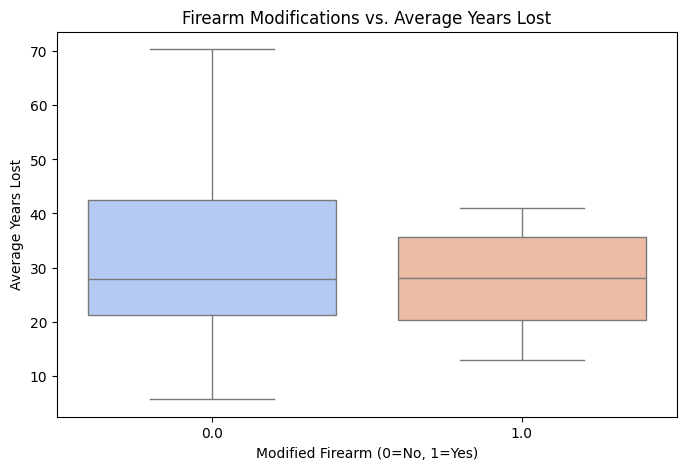

In [11]:
# Boxplot: Firearm Modifications vs Average Years Lost
plt.figure(figsize=(8, 5))
sns.boxplot(x=hypothesis_2_revised['Modified'], y=hypothesis_2_revised['Average Years Lost'], palette="coolwarm")
plt.title("Firearm Modifications vs. Average Years Lost")
plt.xlabel("Modified Firearm (0=No, 1=Yes)")
plt.ylabel("Average Years Lost")
plt.show()


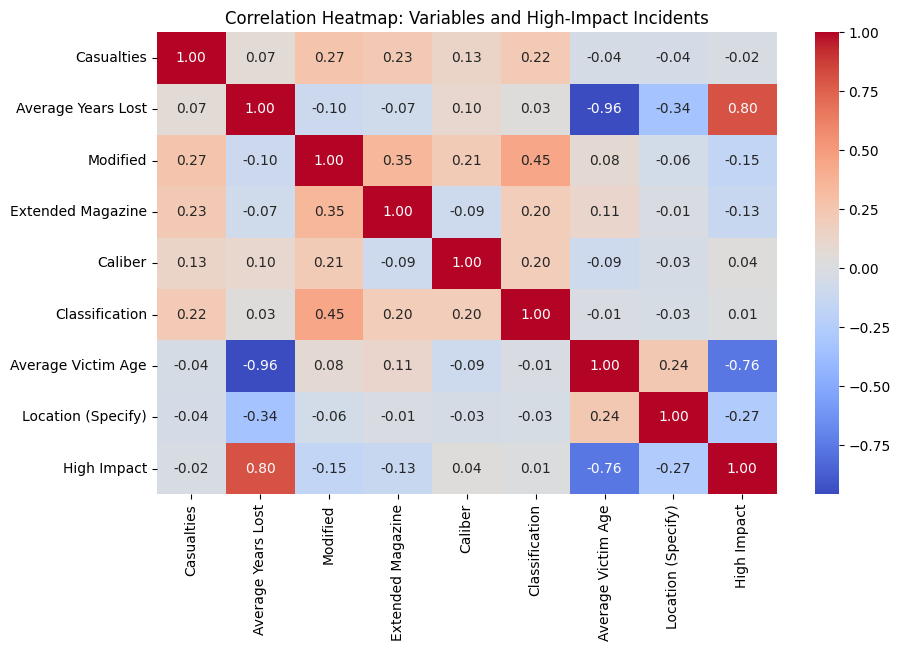

In [12]:
# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(hypothesis_2_revised.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap: Variables and High-Impact Incidents")
plt.show()


<ipython-input-13-40d951b45d2a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance['Coefficient'], y=feature_importance['Feature'], palette="viridis")


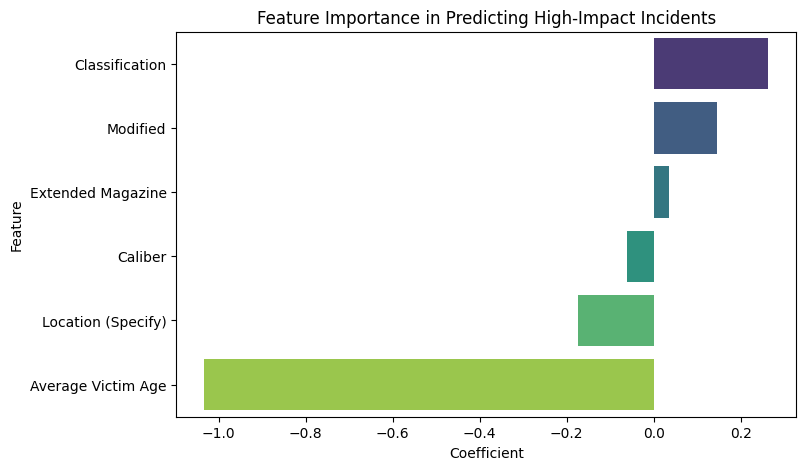

In [13]:
# Bar Plot: Feature Importance
plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importance['Coefficient'], y=feature_importance['Feature'], palette="viridis")
plt.title("Feature Importance in Predicting High-Impact Incidents")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.show()


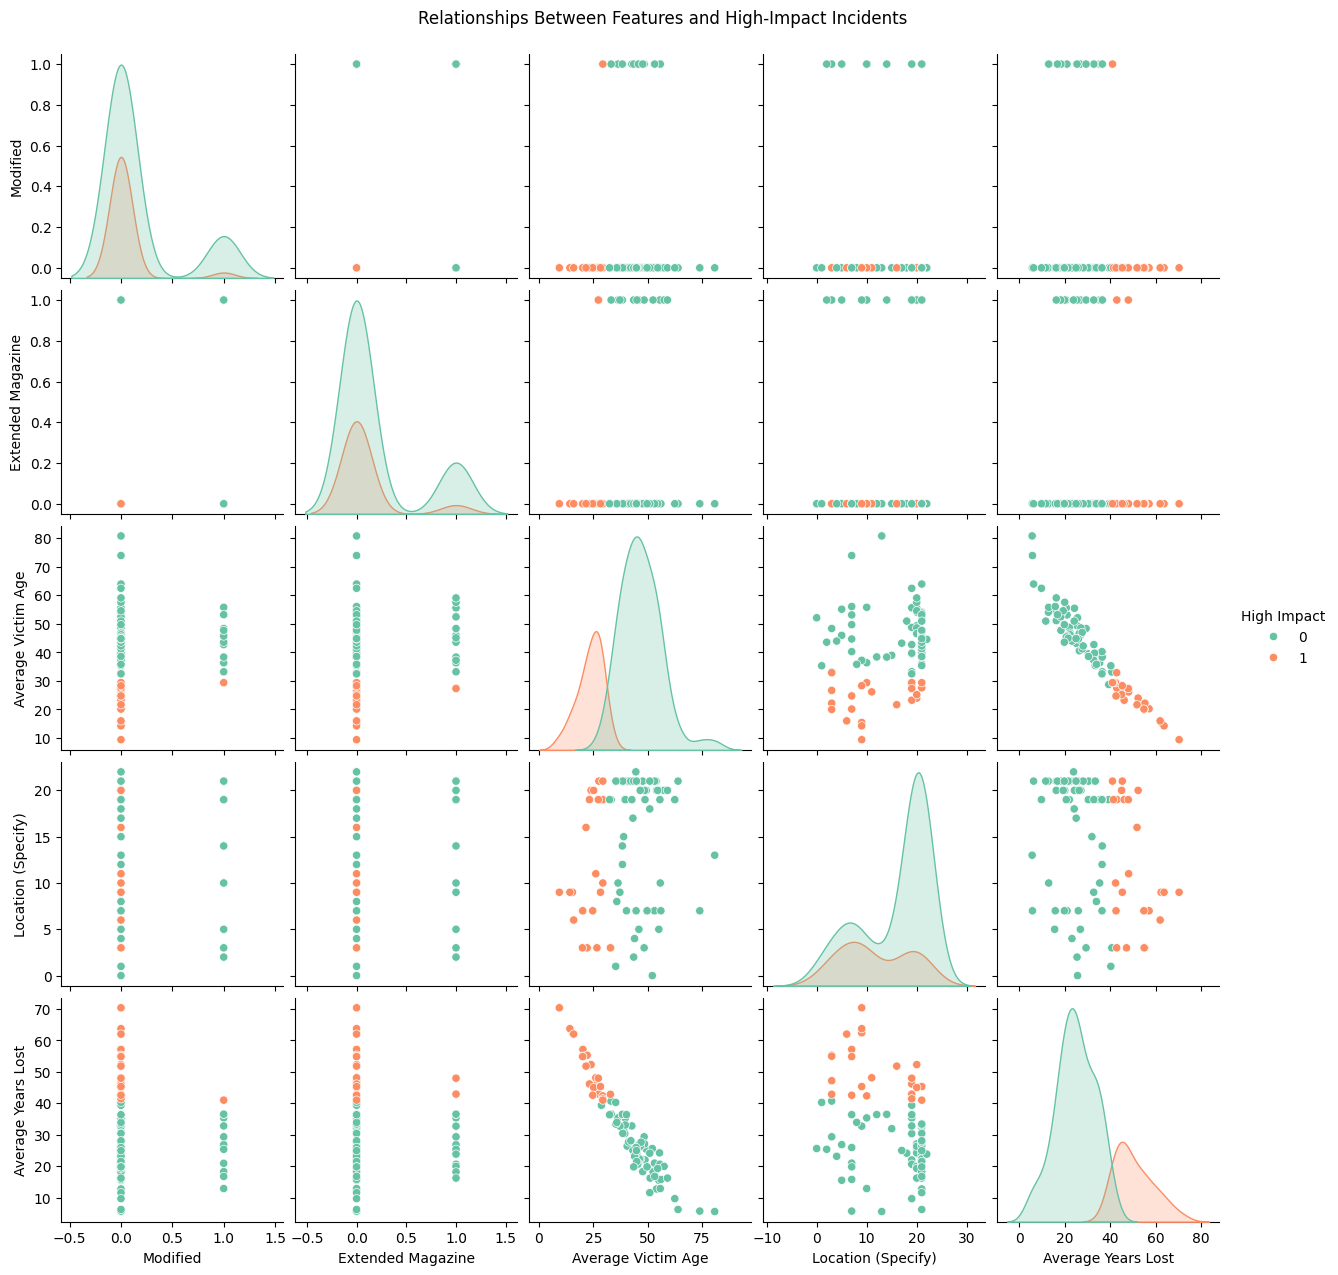

In [14]:
# Pairplot for Relationships Between Features
sns.pairplot(hypothesis_2_revised[['Modified', 'Extended Magazine', 'Average Victim Age',
                                    'Location (Specify)', 'Average Years Lost', 'High Impact']],
             hue="High Impact", palette="Set2", diag_kind="kde")
plt.suptitle("Relationships Between Features and High-Impact Incidents", y=1.02)
plt.show()


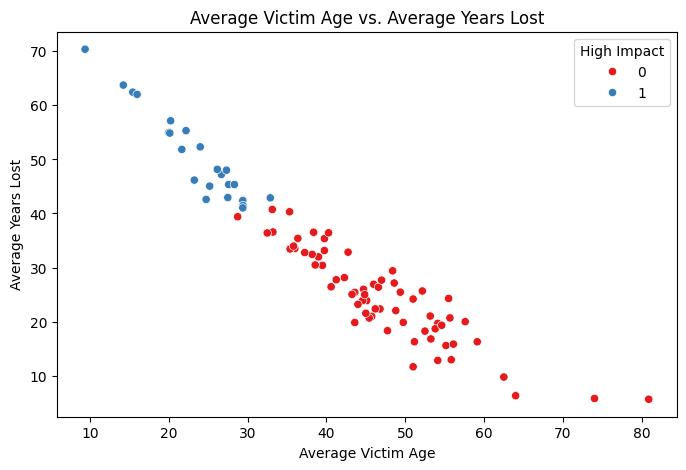

In [15]:
# Scatterplot: Victim Age vs. Average Years Lost
plt.figure(figsize=(8, 5))
sns.scatterplot(x=hypothesis_2_revised['Average Victim Age'], y=hypothesis_2_revised['Average Years Lost'], hue=hypothesis_2_revised['High Impact'], palette="Set1")
plt.title("Average Victim Age vs. Average Years Lost")
plt.xlabel("Average Victim Age")
plt.ylabel("Average Years Lost")
plt.show()


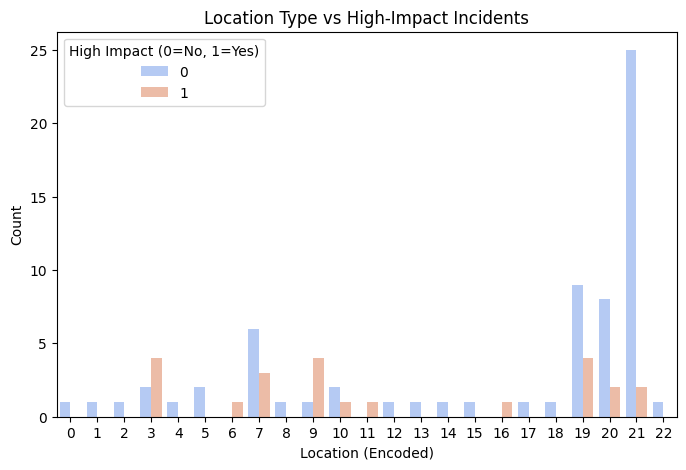

In [16]:
# Countplot: Location vs High Impact
plt.figure(figsize=(8, 5))
sns.countplot(x=hypothesis_2_revised['Location (Specify)'], hue=hypothesis_2_revised['High Impact'], palette="coolwarm")
plt.title("Location Type vs High-Impact Incidents")
plt.xlabel("Location (Encoded)")
plt.ylabel("Count")
plt.legend(title="High Impact (0=No, 1=Yes)")
plt.show()


Temporal Data Preview:
   Year  Incident Count  Casualties  Total Years Lost
0  1995               3          19             473.9
1  1996               2          25             599.8
2  1997               4          32             851.4
3  1998               2          16             504.3
4  1999               6          87            2896.4


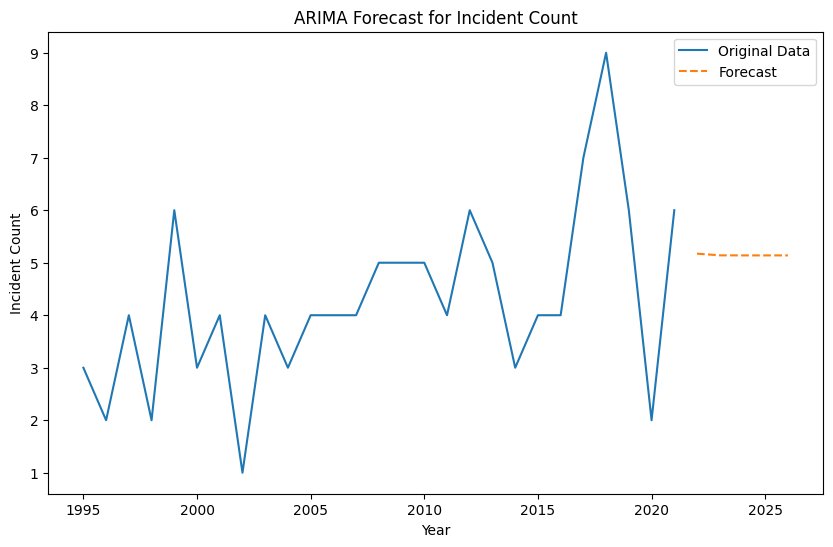

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:         Incident Count   No. Observations:                   27
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -50.955
Date:                Sat, 07 Dec 2024   AIC                            107.910
Time:                        19:59:13   BIC                            111.684
Sample:                             0   HQIC                           108.997
                                 - 27                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0384      0.309      0.125      0.901      -0.566       0.643
ma.L1         -0.8161      0.147     -5.566      0.000      -1.103      -0.529
sigma2         2.8347      0.88

In [18]:
#Hypothesis 3
# Step 1: Aggregate Temporal Data
# Group data by Year to analyze trends in mass shootings and casualties
temporal_data = final_linked_data.groupby('Year').agg({
    'Case #': 'nunique',  # Number of unique incidents
    'Victim Name': 'count',  # Total casualties
    'Years Lost': lambda x: pd.to_numeric(x, errors='coerce').sum(),  # Total years lost
}).rename(columns={
    'Case #': 'Incident Count',
    'Victim Name': 'Casualties',
    'Years Lost': 'Total Years Lost'
}).reset_index()

print("Temporal Data Preview:")
print(temporal_data.head())

# Step 2: ARIMA for Incident Count
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Fit ARIMA model for Incident Count
arima_model_incident = ARIMA(temporal_data['Incident Count'], order=(1, 1, 1))  # Adjust p, d, q as needed
arima_result_incident = arima_model_incident.fit()

# Forecast the next 5 years
forecast_incident = arima_result_incident.forecast(steps=5)

# Plot original data and forecast
plt.figure(figsize=(10, 6))
plt.plot(temporal_data['Year'], temporal_data['Incident Count'], label='Original Data')
plt.plot(range(temporal_data['Year'].max() + 1, temporal_data['Year'].max() + 6), forecast_incident, label='Forecast', linestyle='--')
plt.title("ARIMA Forecast for Incident Count")
plt.xlabel("Year")
plt.ylabel("Incident Count")
plt.legend()
plt.show()

print("ARIMA Model Summary:")
print(arima_result_incident.summary())



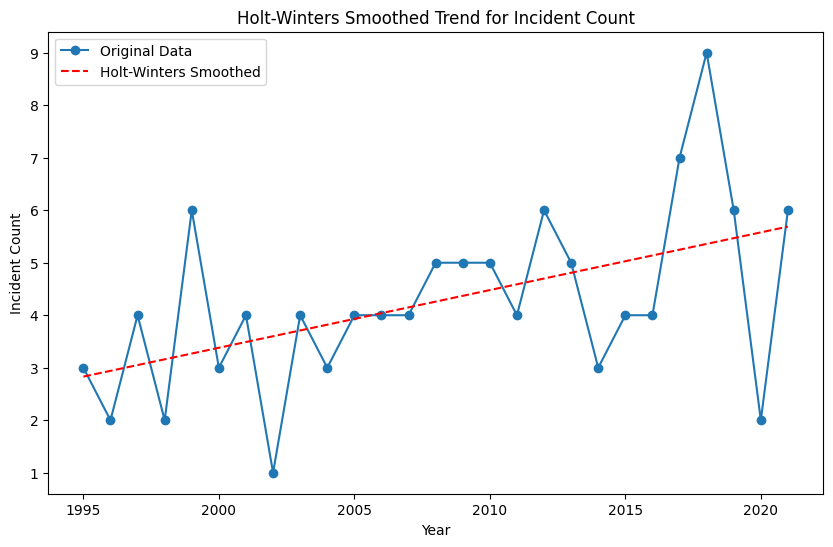

In [19]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# Fit Holt-Winters model for Incident Count
hw_model_incident = ExponentialSmoothing(
    temporal_data['Incident Count'],
    trend='add',  # Additive trend
    seasonal=None  # No seasonal component
)
hw_result_incident = hw_model_incident.fit()

# Add smoothed values to the temporal data
temporal_data['HW Smoothed'] = hw_result_incident.fittedvalues

# Plot original data and smoothed trend
plt.figure(figsize=(10, 6))
plt.plot(temporal_data['Year'], temporal_data['Incident Count'], label='Original Data', marker='o')
plt.plot(temporal_data['Year'], temporal_data['HW Smoothed'], label='Holt-Winters Smoothed', linestyle='--', color='red')
plt.title("Holt-Winters Smoothed Trend for Incident Count")
plt.xlabel("Year")
plt.ylabel("Incident Count")
plt.legend()
plt.show()


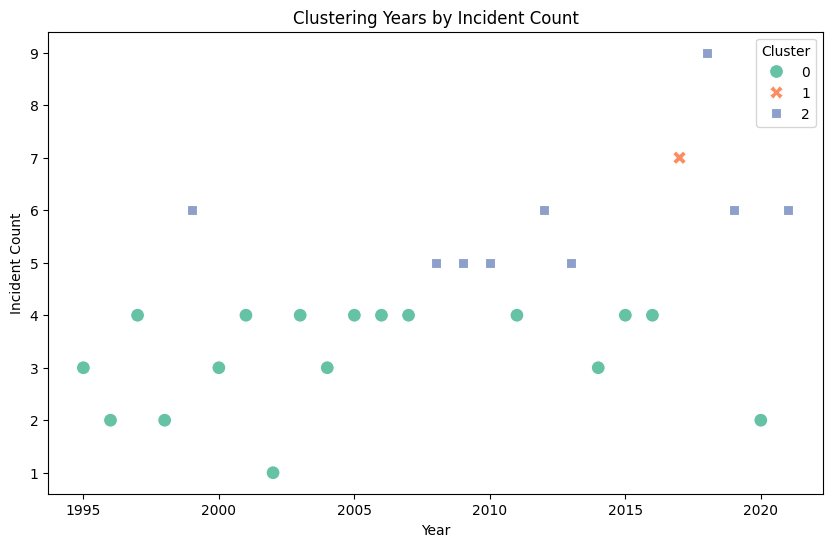

Cluster Centers:
   Incident Count   Casualties  Total Years Lost
0        3.235294    46.235294       1616.494118
1        7.000000  1509.000000      54533.300000
2        5.888889    93.777778       3225.677778


In [20]:
#Hypotheis 4. Doing clustering based on the number of incidents.
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Step 1: Select relevant features for clustering
features = temporal_data[['Incident Count', 'Casualties', 'Total Years Lost']]
scaler = StandardScaler()  # Standardize the features
scaled_features = scaler.fit_transform(features)

# Step 2: Fit K-Means model
kmeans = KMeans(n_clusters=3, random_state=42)  # Set number of clusters
temporal_data['Cluster'] = kmeans.fit_predict(scaled_features)

# Step 3: Visualize Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=temporal_data,
    x='Year',
    y='Incident Count',
    hue='Cluster',
    palette='Set2',
    style='Cluster',
    s=100
)
plt.title("Clustering Years by Incident Count")
plt.xlabel("Year")
plt.ylabel("Incident Count")
plt.legend(title="Cluster")
plt.show()

# Step 4: Analyze Cluster Centers
# Denormalize cluster centers for interpretability
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
print("Cluster Centers:")
print(pd.DataFrame(cluster_centers, columns=features.columns))


In [22]:
# Use median for Year to avoid decimals
cluster_summary = temporal_data.groupby('Cluster').median()
print("Cluster Characteristics (Median Year):")
print(cluster_summary)


Cluster Characteristics (Median Year):
           Year  Incident Count  Casualties  Total Years Lost  HW Smoothed
Cluster                                                                   
0        2004.0             4.0        38.0            1117.2     3.819699
1        2017.0             7.0      1509.0           54533.3     5.248270
2        2012.0             6.0        82.0            2153.3     4.698820


In [23]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def evaluate_clustering(data, labels):
    """
    Evaluate clustering performance using silhouette, Davies-Bouldin, and Calinski-Harabasz scores.
    """
    silhouette = silhouette_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    calinski_harabasz = calinski_harabasz_score(data, labels)

    return {
        "Silhouette Score": silhouette,
        "Davies-Bouldin Index": davies_bouldin,
        "Calinski-Harabasz Index": calinski_harabasz
    }


In [24]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Standardize the features
features = temporal_data[['Incident Count', 'Casualties', 'Total Years Lost']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_features)

# Evaluate K-Means
kmeans_evaluation = evaluate_clustering(scaled_features, kmeans_labels)
print("K-Means Evaluation Metrics:")
print(kmeans_evaluation)


K-Means Evaluation Metrics:
{'Silhouette Score': 0.488385989604046, 'Davies-Bouldin Index': 0.49650191880414846, 'Calinski-Harabasz Index': 72.82335396233498}


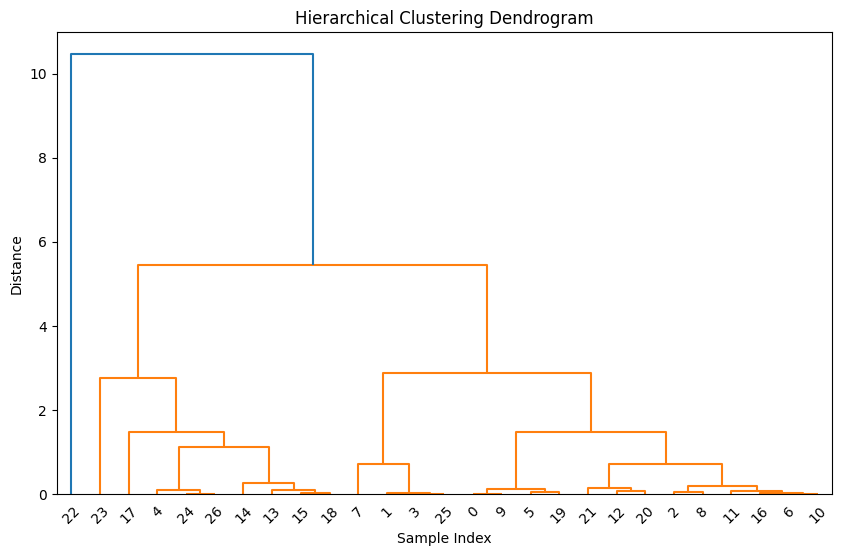

Hierarchical Clustering Evaluation Metrics:
{'Silhouette Score': 0.488385989604046, 'Davies-Bouldin Index': 0.49650191880414857, 'Calinski-Harabasz Index': 72.82335396233496}


In [25]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import matplotlib.pyplot as plt

# Apply Hierarchical Clustering
linkage_matrix = linkage(scaled_features, method='ward')  # Ward's method for minimization of variance
hierarchical_labels = fcluster(linkage_matrix, t=3, criterion='maxclust')  # Force 3 clusters

# Plot Dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

# Evaluate Hierarchical Clustering
hierarchical_evaluation = evaluate_clustering(scaled_features, hierarchical_labels)
print("Hierarchical Clustering Evaluation Metrics:")
print(hierarchical_evaluation)


In [28]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler

# Step 1: Prepare Data
features = temporal_data[['Incident Count', 'Casualties', 'Total Years Lost']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Step 2: Build Autoencoder for Dimensionality Reduction
input_dim = scaled_features.shape[1]  # Number of features
latent_dim = 2  # Number of dimensions for low-dimensional representation

# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(latent_dim, activation='relu')(encoded)

# Decoder
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Autoencoder Model
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Encoder Model
encoder = Model(inputs=input_layer, outputs=encoded)

# Compile Autoencoder
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# Step 3: Train Autoencoder
autoencoder.fit(scaled_features, scaled_features, epochs=50, batch_size=16, shuffle=True, verbose=1)

# Step 4: Extract Latent Representations
latent_features = encoder.predict(scaled_features)

# Step 5: K-Means Clustering on Latent Representations
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(latent_features)

# Step 6: Evaluate Clustering
def evaluate_clustering(data, labels):
    silhouette = silhouette_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    calinski_harabasz = calinski_harabasz_score(data, labels)
    return {
        "Silhouette Score": silhouette,
        "Davies-Bouldin Index": davies_bouldin,
        "Calinski-Harabasz Index": calinski_harabasz
    }

# Evaluate K-Means on Latent Features
dec_evaluation = evaluate_clustering(latent_features, kmeans_labels)
print("Deep Embedded Clustering (DEC) Evaluation Metrics:")
print(dec_evaluation)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,797 (69.52 KB)

 Trainable params: 17,797 (69.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 1.1154
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.3481 
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.0760 
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0291  
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0309 
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2947  
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.3119 
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2944
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2333  
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.2372 
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9351 
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1884  
Epoch 13/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8976 
Epoch 14/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0768
Epoch 15/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1410 
Epoch 16/50
2/2 ━━━━━━━━

In [29]:
# Compare K-Means and DEC Metrics
comparison_df = pd.DataFrame({
    "Metric": ["Silhouette Score", "Davies-Bouldin Index", "Calinski-Harabasz Index"],
    "K-Means": [kmeans_evaluation['Silhouette Score'], kmeans_evaluation['Davies-Bouldin Index'], kmeans_evaluation['Calinski-Harabasz Index']],
    "DEC": [dec_evaluation['Silhouette Score'], dec_evaluation['Davies-Bouldin Index'], dec_evaluation['Calinski-Harabasz Index']]
})

print("Comparison of K-Means and Deep Embedded Clustering:")
print(comparison_df)


Comparison of K-Means and Deep Embedded Clustering:
                    Metric    K-Means        DEC
0         Silhouette Score   0.488386   0.622030
1     Davies-Bouldin Index   0.496502   0.470022
2  Calinski-Harabasz Index  72.823354  77.279877


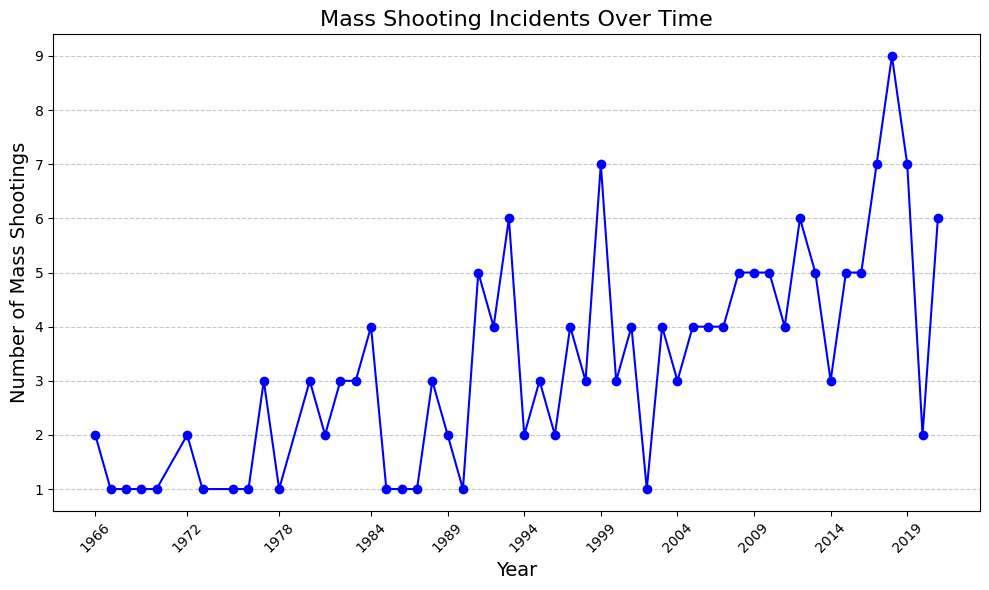

In [ ]:
import matplotlib.pyplot as plt

# Ensure 'Year' is numeric and drop NaN values
trend_data['Year'] = pd.to_numeric(trend_data['Year'], errors='coerce')  # Convert Year to numeric
trend_data['Mass Shootings (Incidents)'] = pd.to_numeric(trend_data['Mass Shootings (Incidents)'], errors='coerce')  # Ensure numeric
trend_data = trend_data.dropna(subset=['Year', 'Mass Shootings (Incidents)'])  # Drop rows with NaN in key columns

# Sort by Year
trend_data = trend_data.sort_values('Year')

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(trend_data['Year'], trend_data['Mass Shootings (Incidents)'], marker='o', linestyle='-', color='blue')

# Add titles and labels
plt.title('Mass Shooting Incidents Over Time', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Mass Shootings', fontsize=14)

# Enhance x-axis ticks for readability
plt.xticks(ticks=trend_data['Year'][::5], rotation=45)  # Show every 5th year
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()
